# PD & Scorecard Model

Topics Covered Here

    1. Loading the Libraries & Dataset
    2. Data Summary
    3. Partitioning Data
    
    4. Deleting the Reference Dummy Variables
    5. PD Model- Logistic Regression
    6. Build Logistic Regression with P-Values
    
    7. Variable Selection
    8. PD Model Testing
        A. Out-of-sample validation (test)
        B. Gini and Kolmogorov-Smirnov
    
    9. Applying the PD Model
        A Calculating PD of individual accounts
        B Creating a Scorecard
        C Caclulating Credit Score
        D From Credit Score to PD
        E Setting Cut-off Rates for PD


## 1. Loading the Libraries & Dataset

In [1]:
#import some necessary librairies

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x)) #Limiting floats output to 3 decimal points
os.getcwd()

'C:\\Users\\sohai\\Desktop\\My Personal\\1. FinTech\\Stephanie\\Credit Risk'

In [2]:
#Change the working directory
%cd "C:\Users\sohai\Desktop\My Personal\1. FinTech\Stephanie\Credit Risk"
print(os.listdir())

C:\Users\sohai\Desktop\My Personal\1. FinTech\Stephanie\Credit Risk
['.ipynb_checkpoints', '3.A- Binning of Variables.ipynb', '3.B- PD & Scorecard Model.ipynb', '3.C- Population Stability Index.ipynb', '4. LGD, EAD & EL Models.ipynb', 'German binned_data.xlsx', 'German Credit Data.xlsx', 'German Credit Final CRM.xlsx', 'lgd_model_stage_2.sav', 'pd_model.sav', 'reg_lgd.sav', 'scorecard values.xlsx', 'Test Set Score.csv']


Variables Description

    1. Age (numeric)
    2. Sex (text: male, female)
    3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
    4. Housing (text: own, rent, or free)
    5. Saving accounts (text - little, moderate, quite rich, rich)
    6. Checking account (numeric, in DM - Deutsch Mark)
    7. Duration (numeric, in month)
    8. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
    9. Risk (good or bad. bad means default. Dependent Variable)
    10. Credit amount (numeric, in DM)
    11. Recovered Principle- Amount of Princeiple recovred from bad cases
    12. Recoveries- Total recoveries made from bad cases
    



In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe

df = pd.read_excel("German binned_data.xlsx", sheet_name= 'Sheet1', date_parser=True)
df.head()

,Unnamed: 0,Age,Duration,Risk,Credit amount,Recovered_Principle,Recoveries,default,Sex_female,Sex_male,...,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:<3500,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
0,0,67,6,good,17000,17000.00,0.00,0,0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,22,48,bad,11000,9942.67,0.00,1,1,0,...,0,0,0,1,0,0,1,1,1,0
2,2,49,12,good,32200,32200.00,0.00,0,0,1,...,1,0,0,0,0,0,0,0,0,1
3,3,45,42,good,12000,12000.00,0.00,0,0,1,...,0,0,0,1,0,0,0,1,1,0
4,4,53,24,bad,7000,167.56,0.00,1,0,1,...,0,0,1,0,0,1,1,1,1,0


## 2. Data Summary

In [4]:
df.columns

Index(['Unnamed: 0', 'Age', 'Duration', 'Risk', 'Credit amount',
       'Recovered_Principle', 'Recoveries', 'default', 'Sex_female',
       'Sex_male', 'Job_0', 'Job_1', 'Job_2', 'Job_3', 'Housing_free',
       'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age:<25', 'Age:25-35',
       'Age:35-45', 'Age:45-50', 'Age:>= 50', 'Duration:<7', 'Duration:7-14',
       'Duration:14-21', 'Duration:21-36', 'Duration:>= 36', 'Loan:<3500',
       'Loan:3.5k-8k', 'Loan:8k-12k', 'Loan:12k-20k', 'Loan:20-26k',
       'Loan:>= 26k'],
      dtype='object')

In [5]:
df1 = df.copy()
df1.drop(['Unnamed: 0', 'Age', 'Credit amount', 'Duration', 'Risk', 'Recovered_Principle', 'Recoveries'], axis=1, inplace=True)
df1.head(2)

,default,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent,...,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:<3500,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0
1,1,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0


As we can see below, summary is shown only for numeric variables

In [6]:
df1.shape

(901, 41)

## 3. Partitioning Data

In [7]:
# Encoding the dependent variable 1st

Y = df1.loc[:, 'default']
df1 = df1.drop(['default'], axis=1)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(Y)
enc_y = encoder.transform(Y)
print(enc_y[:10])


[0 1 0 0 1 0 0 0 0 1]


In [8]:
# In case we want Original labels in dependent variable
encoder.inverse_transform(enc_y)[0:10]
encoder.classes_

array([0, 1], dtype=int64)

In [9]:
X = df1
print(X.shape)

(901, 40)


In [10]:
# Partition the dataset in train + validation sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, enc_y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))


X_train : (720, 40)
X_test : (181, 40)
y_train : (720,)
y_test : (181,)


## 4. Deleting the Reference Dummy Variables



We created these dummy variable earlier without one hot encoding. Suppose a variable had 6 categories so we created 6 dummy variables. Now, we need to delete one of the dummies variables from each original variable otherwise we would face "dummy variable trap" and it might lead to redundancy.

Earlier while creating dummies,we had created reference dummy variable for each original variable. Here we would simply delete the reference dummy category. Whatever variable we dont include becomes our reference or benchmark variable. Suppose for grade, we have dummy variables- a,b,c,d. If we remove d, then d is oure reference variable. For a borrower/oberservation, if all a,b,c are zero, it means d is 1.


In [11]:
X_train.columns

Index(['Sex_female', 'Sex_male', 'Job_0', 'Job_1', 'Job_2', 'Job_3',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age:<25', 'Age:25-35',
       'Age:35-45', 'Age:45-50', 'Age:>= 50', 'Duration:<7', 'Duration:7-14',
       'Duration:14-21', 'Duration:21-36', 'Duration:>= 36', 'Loan:<3500',
       'Loan:3.5k-8k', 'Loan:8k-12k', 'Loan:12k-20k', 'Loan:20-26k',
       'Loan:>= 26k'],
      dtype='object')

In [12]:
ref_categories = ['Sex_female', 'Job_0', 'Housing_free', 'Saving accounts_little', 'Checking account_little',
                 'Purpose_business', 'Age:<25', 'Duration:<7', 'Loan:<3500']

In [13]:

X_train = X_train.drop(ref_categories, axis=1)
X_train.head(2)


,Sex_male,Job_1,Job_2,Job_3,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,...,Age:>= 50,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
843,1,0,1,0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
535,1,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,1,1,0


## 5. PD Model- Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# We create an instance of an object from the 'LogisticRegression' class.
reg = LogisticRegression()

In [15]:
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

reg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
reg.intercept_
# Displays the intercept contain in the estimated ("fitted") object from the 'LogisticRegression' class.

array([-1.2390515])

In [17]:
reg.coef_
# Displays the coefficients contained in the estimated ("fitted") object from the 'LogisticRegression' class.

array([[-0.17065367,  0.169872  , -0.02921883,  0.01498412, -0.59773624,
        -0.06740103, -0.06725811, -1.19879173, -0.64852512,  0.59552795,
        -0.01400907,  0.11342675,  0.12261534,  0.50165098,  0.03650034,
        -0.24892598,  0.38680358,  0.23102443, -0.04616683, -0.61862869,
        -0.85765383, -0.52285394,  0.30300308,  0.55505075,  0.60777115,
         1.53367694,  0.26894096,  0.090193  , -0.4028451 ,  0.99223429,
        -0.64988343]])

In [18]:
feature_name = X_train.columns.values
feature_name
# Stores the names of the columns of a dataframe in a variable.

array(['Sex_male', 'Job_1', 'Job_2', 'Job_3', 'Housing_own',
       'Housing_rent', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age:25-35',
       'Age:35-45', 'Age:45-50', 'Age:>= 50', 'Duration:7-14',
       'Duration:14-21', 'Duration:21-36', 'Duration:>= 36',
       'Loan:3.5k-8k', 'Loan:8k-12k', 'Loan:12k-20k', 'Loan:20-26k',
       'Loan:>= 26k'], dtype=object)

In [19]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table

,Feature name,Coefficients
0,Intercept,-1.24
1,Sex_male,-0.17
2,Job_1,0.17
3,Job_2,-0.03
4,Job_3,0.01
5,Housing_own,-0.60
6,Housing_rent,-0.07
7,Saving accounts_moderate,-0.07
8,Saving accounts_quite rich,-1.20
9,Saving accounts_rich,-0.65


## 6. Build Logistic Regression with P-Values
Logistic regression doesnt have built-in module to calculate multivariate p-values. Here we create a function that does the multivariate p-values calculation.We use logreg with p-values so that we would do variable selection on the basis of p-values.



Note- If any two variables have correlation either 1 or NaN , logreg with P-values wouldnt work.

In [20]:
# P values for sklearn logistic regression.

# Class to display p-values for logistic regression in sklearn.

from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        #### Get p-values for the fitted model ####
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] ### two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [21]:
reg = LogisticRegression_with_p_values()
# We create an instance of an object from the newly created 'LogisticRegression_with_p_values()' class.

In [22]:
reg.fit(X_train, y_train)
# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.



In [23]:
# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.24
1,Sex_male,-0.17
2,Job_1,0.17
3,Job_2,-0.03
4,Job_3,0.01
5,Housing_own,-0.60
6,Housing_rent,-0.07
7,Saving accounts_moderate,-0.07
8,Saving accounts_quite rich,-1.20
9,Saving accounts_rich,-0.65


In [24]:
# This is a list.
p_values = reg.p_values
# We take the result of the newly added method 'p_values' and store it in a variable 'p_values'.

In [25]:
# Add the intercept for completeness. since intercept doesnt have p-value, we just add a NaN
p_values = np.append(np.nan, np.array(p_values))
# We add the value 'NaN' in the beginning of the variable with p-values.

In [26]:
summary_table['p_values'] = p_values
# In the 'summary_table' dataframe, we add a new column, called 'p_values', containing the values from the 'p_values' variable.

In [27]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.24,nan
1,Sex_male,-0.17,0.38
2,Job_1,0.17,0.75
3,Job_2,-0.03,0.95
4,Job_3,0.01,0.98
5,Housing_own,-0.60,0.04
6,Housing_rent,-0.07,0.84
7,Saving accounts_moderate,-0.07,0.82
8,Saving accounts_quite rich,-1.20,0.03
9,Saving accounts_rich,-0.65,0.17


## 7. Variable Selection

We are going to remove some features. If the coefficients for all of the dummy variables for an original variable are not statistically significant (p-value greater than 0.005), we would remove it.

Suppose, in an original variable, there are some dummies, that have high p-values (statistically not significant or p >0.05) and other dummies have low p (statistically significant or p <0.05), we keep this original variable (keep all the dummies for this origina variable). If for a variable, none of the dummy variables have significant p-values, we would remove them and retrain the model.

We do that by specifying another list of dummy variables as reference categories, and a list of variables to remove. Then, we are going to drop the two datasets from the original list of dummy variables.


As we can see, none of the dummies in Job and Purpose are NOT statisitically significant. let's remove them.

To do that, in reference categories, we only keep the variables whose one or more dummies are statistically significant and then drop the reference categories from original dataset.

In [28]:
ref_categories

['Sex_female',
 'Job_0',
 'Housing_free',
 'Saving accounts_little',
 'Checking account_little',
 'Purpose_business',
 'Age:<25',
 'Duration:<7',
 'Loan:<3500']

In [29]:
X_train.columns

Index(['Sex_male', 'Job_1', 'Job_2', 'Job_3', 'Housing_own', 'Housing_rent',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age:25-35', 'Age:35-45',
       'Age:45-50', 'Age:>= 50', 'Duration:7-14', 'Duration:14-21',
       'Duration:21-36', 'Duration:>= 36', 'Loan:3.5k-8k', 'Loan:8k-12k',
       'Loan:12k-20k', 'Loan:20-26k', 'Loan:>= 26k'],
      dtype='object')

In [30]:
# We keep variable those are stastistically significant
X_train_with_p = X_train.loc[:, ['Sex_male', 'Housing_own', 'Housing_rent', 'Saving accounts_moderate',
                                 'Saving accounts_quite rich', 'Saving accounts_rich', 'Checking account_moderate',
                                 'Checking account_rich', 'Age:25-35', 'Age:35-45', 'Age:45-50', 'Age:>= 50',
                                 'Duration:7-14', 'Duration:14-21', 'Duration:21-36', 'Duration:>= 36', 
                                 'Loan:3.5k-8k', 'Loan:8k-12k', 'Loan:12k-20k', 'Loan:20-26k', 'Loan:>= 26k']]

X_train_with_p.head(2)

,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Age:25-35,Age:35-45,...,Age:>= 50,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
843,1,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
535,1,0,1,0,0,0,0,1,1,0,...,0,0,0,1,0,0,1,1,1,0


In [31]:
ref_categories_with_p = ['Sex_female', 'Housing_free', 'Saving accounts_little',  'Checking account_little',
                         'Age:<25', 'Duration:<7', 'Loan:<3500']


In [32]:

# Here we run a new model.
reg2 = LogisticRegression_with_p_values()
reg2.fit(X_train_with_p, y_train)

feature_name = X_train_with_p.columns.values


# Same as above.
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg2.intercept_[0]]
summary_table = summary_table.sort_index()


# We add the 'p_values' here, just as we did before.
p_values = reg2.p_values
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table
# Here we get the results for our final PD model.

,Feature name,Coefficients,p_values
0,Intercept,-1.14,nan
1,Sex_male,-0.18,0.35
2,Housing_own,-0.68,0.01
3,Housing_rent,-0.10,0.75
4,Saving accounts_moderate,-0.05,0.88
5,Saving accounts_quite rich,-1.22,0.02
6,Saving accounts_rich,-0.62,0.18
7,Checking account_moderate,0.60,0.00
8,Checking account_rich,-0.03,0.94
9,Age:25-35,-0.04,0.87


In [33]:
import pickle
pickle.dump(reg2, open('pd_model.sav', 'wb'))
# Here we export our model to a 'SAV' file with file name 'pd_model.sav'.

In [34]:
ref_categories_with_p

['Sex_female',
 'Housing_free',
 'Saving accounts_little',
 'Checking account_little',
 'Age:<25',
 'Duration:<7',
 'Loan:<3500']

In [35]:
X_test.columns.values

array(['Sex_female', 'Sex_male', 'Job_0', 'Job_1', 'Job_2', 'Job_3',
       'Housing_free', 'Housing_own', 'Housing_rent',
       'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_little', 'Checking account_moderate',
       'Checking account_rich', 'Purpose_business', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others', 'Age:<25',
       'Age:25-35', 'Age:35-45', 'Age:45-50', 'Age:>= 50', 'Duration:<7',
       'Duration:7-14', 'Duration:14-21', 'Duration:21-36',
       'Duration:>= 36', 'Loan:<3500', 'Loan:3.5k-8k', 'Loan:8k-12k',
       'Loan:12k-20k', 'Loan:20-26k', 'Loan:>= 26k'], dtype=object)

## 8. PD Model Testing

### 8.A Out-of-sample validation (test)




In [36]:
# Here, we keep the same variables that we used in our final PD model along with reference categories
X_test_p_with_ref_cat = X_test.loc[:,['Sex_female', 'Sex_male','Housing_free', 'Housing_own', 'Housing_rent',
                                       'Saving accounts_little', 'Saving accounts_moderate',
                                       'Saving accounts_quite rich','Saving accounts_rich',
                                       'Checking account_little', 'Checking account_moderate',
                                       'Checking account_rich', 'Age:<25', 'Age:25-35', 'Age:35-45', 'Age:45-50',
                                       'Age:>= 50', 'Duration:<7', 'Duration:7-14', 'Duration:14-21',
                                       'Duration:21-36', 'Duration:>= 36', 'Loan:<3500', 'Loan:3.5k-8k',
                                       'Loan:8k-12k', 'Loan:12k-20k','Loan:20-26k', 'Loan:>= 26k']]

X_test_p_with_ref_cat.head(3)

,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,...,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:<3500,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
60,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,1,1,0
338,0,1,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,1,1,1,0
725,1,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,1,1,0


In [37]:
X_test_with_P = X_test_p_with_ref_cat.drop(ref_categories_with_p, axis=1)
X_test_with_P.head(3)


,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Age:25-35,Age:35-45,...,Age:>= 50,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
60,1,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,1,1,0
338,1,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0
725,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0


This is how model.predict works

    1. Multiplies the values of the variables by the model coefficients, this yields the log of odds of being good
    2) an exponent is raised to the power of the log of odds; this yields the odds of being good and the estimated probability of being good
    3) the estimated probabilities are categorized into being good or bad by applying a cut-off. Default cut-off is 0.5

y_pred_test is the predicted values for the dependent variable (targets) based on the test set. This is an array of predicted discrete classess (in this case, 0s and 1s).


In [38]:
y_pred_test = reg2.model.predict(X_test_with_P)
y_pred_test[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

We can also calculate the predicted probability values for the dependent variable 

This is an array of arrays of predicted class probabilities for all classes. In this case, the first value of every sub-array is the probability for the observation to belong to the first class, i.e. 0, and the second value is the probability for the observation to belong to the 2nd class, i.e. 1.

In [39]:
y_hat_test_proba = reg2.model.predict_proba(X_test_with_P)
y_hat_test_proba[:10]

array([[0.61200177, 0.38799823],
       [0.68326242, 0.31673758],
       [0.90929589, 0.09070411],
       [0.87006577, 0.12993423],
       [0.4407729 , 0.5592271 ],
       [0.68816997, 0.31183003],
       [0.90544904, 0.09455096],
       [0.58153211, 0.41846789],
       [0.68326242, 0.31673758],
       [0.42454467, 0.57545533]])


We store only the 2nd variable probabilities (1) in a variable below. This variable contains an array of probabilities of being 1.

In [40]:
y_hat_test_proba = y_hat_test_proba[: ][: , 1]
y_hat_test_proba[0:10]

array([0.38799823, 0.31673758, 0.09070411, 0.12993423, 0.5592271 ,
       0.31183003, 0.09455096, 0.41846789, 0.31673758, 0.57545533])

In [41]:
dataset = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test}, columns=['Actual', 'Predicted'])
dataset.head(5)

,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1


In [42]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_pred_test, y_test)
print("Confusion Matrix: \n{}".format(cm))

normalized_cm = cm.astype('float') / np.sum(cm)
print("\nNormalized Confusion Matrix: \n{}".format(np.round(normalized_cm,2)))



Confusion Matrix: 
[[112  34]
 [ 23  12]]

Normalized Confusion Matrix: 
[[0.62 0.19]
 [0.13 0.07]]


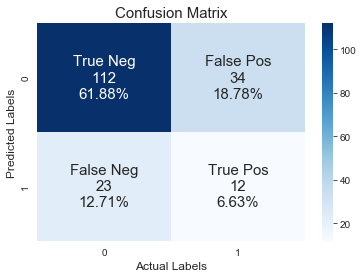

In [43]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', annot_kws={"size":15})

plt.title('Confusion Matrix', fontsize = 15) # title with fontsize 20
plt.xlabel('Actual Labels', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Predicted Labels', fontsize = 12) # y-axis label with fontsize 15

plt.show()

In [44]:
print("Accuracy paramets: \n{}".format(classification_report(y_pred_test, y_test)))

Accuracy paramets: 
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       146
           1       0.26      0.34      0.30        35

    accuracy                           0.69       181
   macro avg       0.55      0.55      0.55       181
weighted avg       0.72      0.69      0.70       181



AUC Value:  0.62


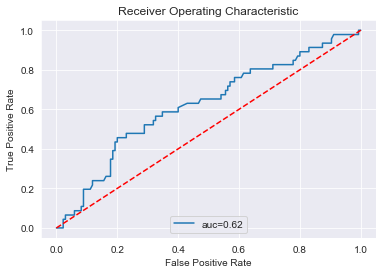

In [45]:
# ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Keeping the predicted probabilities for outcome (1 or liver patient) only
#y_pred_proba = final_model.predict_proba(X_test_std)[::,1]


fpr, tpr, _ = roc_curve(y_test,  y_hat_test_proba)
auc = roc_auc_score(y_test, y_hat_test_proba)
auc = float("{:.2f}".format(auc))
print("AUC Value: ", auc)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1],'r--')
plt.title('Receiver Operating Characteristic')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=8)
plt.show()


### 8.B Gini and Kolmogorov-Smirnov

The maximum difference between the cumulative distribution functions of good and bad borrowers.

    - Gini = AUC * 2 - 1
    - AUC =  (Gini +1)/2



In [46]:
dataset['Predicted_Prob'] = y_hat_test_proba
dataset = dataset.sort_values('Predicted_Prob')

dataset = dataset.reset_index() # we reset the index

dataset.head(5)

,index,Actual,Predicted,Predicted_Prob
0,171,0,0,0.03
1,62,1,0,0.04
2,102,0,0,0.04
3,123,0,0,0.04
4,77,0,0,0.07


In [47]:
dataset['Cumulative N Population'] = dataset.index + 1
# We calculate the cumulative number of all observations.
# We use the new index for that. Since indexing in ython starts from 0, we add 1 to each index.
dataset['Cumulative N survived'] = dataset['Actual'].cumsum()
# We calculate cumulative number of 'good', which is the cumulative sum of the column with actual observations.
dataset['Cumulative N not-survived'] = dataset['Cumulative N Population'] - dataset['Actual'].cumsum()
# We calculate cumulative number of 'bad', which is
# the difference between the cumulative number of all observations and cumulative number of 'good' for each row.
dataset.head(3)


,index,Actual,Predicted,Predicted_Prob,Cumulative N Population,Cumulative N survived,Cumulative N not-survived
0,171,0,0,0.03,1,0,1
1,62,1,0,0.04,2,1,1
2,102,0,0,0.04,3,1,2


In [48]:
dataset['Cumulative Perc Population'] = dataset['Cumulative N Population'] / (dataset.shape[0])
# We calculate the cumulative percentage of all observations.
dataset['Cumulative Perc survived'] = dataset['Cumulative N survived'] / dataset['Actual'].sum()
# We calculate cumulative percentage of 'survived or 1 class'.
dataset['Cumulative Perc not-survived'] = dataset['Cumulative N not-survived'] / (dataset.shape[0] - dataset['Actual'].sum())
# We calculate the cumulative percentage of 'died or not-survived or 0 class'.

display(dataset.head(3))

display(dataset.tail(5))

,index,Actual,Predicted,Predicted_Prob,Cumulative N Population,Cumulative N survived,Cumulative N not-survived,Cumulative Perc Population,Cumulative Perc survived,Cumulative Perc not-survived
0,171,0,0,0.03,1,0,1,0.01,0.00,0.01
1,62,1,0,0.04,2,1,1,0.01,0.02,0.01
2,102,0,0,0.04,3,1,2,0.02,0.02,0.01


,index,Actual,Predicted,Predicted_Prob,Cumulative N Population,Cumulative N survived,Cumulative N not-survived,Cumulative Perc Population,Cumulative Perc survived,Cumulative Perc not-survived
176,135,1,1,0.70,177,45,132,0.98,0.98,0.98
177,152,1,1,0.74,178,46,132,0.98,1.00,0.98
178,89,0,1,0.75,179,46,133,0.99,1.00,0.99
179,96,0,1,0.75,180,46,134,0.99,1.00,0.99
180,12,0,1,0.77,181,46,135,1.00,1.00,1.00


Text(0.5, 1.0, 'Gini')

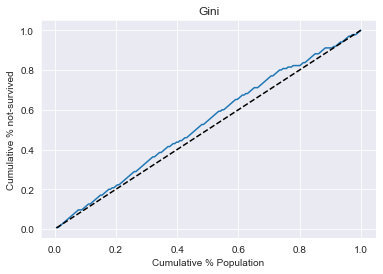

In [49]:
# Plot Gini
plt.plot(dataset['Cumulative Perc Population'], dataset['Cumulative Perc not-survived'])
# We plot the cumulative percentage of all along the x-axis and the cumulative percentage 'good' along the y-axis,
# thus plotting the Gini curve.
plt.plot(dataset['Cumulative Perc Population'], dataset['Cumulative Perc Population'], linestyle = '--', color = 'k')
# We plot a seconary diagonal line, with dashed line style and black color.
plt.xlabel('Cumulative % Population')
# We name the x-axis "Cumulative % Population".
plt.ylabel('Cumulative % not-survived')
# We name the y-axis "Cumulative % Bad".
plt.title('Gini')
# We name the graph "Gini".

In [50]:
np.unique(y_test, return_counts=True)

(array([0, 1], dtype=int64), array([135,  46], dtype=int64))

In [51]:
Gini = auc * 2 - 1
# Here we calculate Gini from AUROC.
Gini

0.24

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

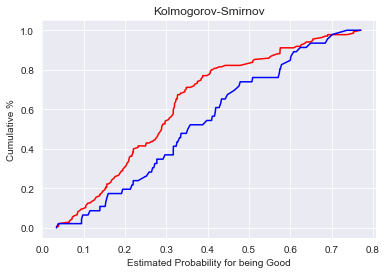

In [52]:
# Plot KS
plt.plot(dataset['Predicted_Prob'], dataset['Cumulative Perc not-survived'], color = 'r')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'bad' along the y-axis,
# colored in red.
plt.plot(dataset['Predicted_Prob'], dataset['Cumulative Perc survived'], color = 'b')
# We plot the predicted (estimated) probabilities along the x-axis and the cumulative percentage 'good' along the y-axis,
# colored in red.
plt.xlabel('Estimated Probability for being Good')
# We name the x-axis "Estimated Probability for being Good".
plt.ylabel('Cumulative %')
# We name the y-axis "Cumulative %".
plt.title('Kolmogorov-Smirnov')
# We name the graph "Kolmogorov-Smirnov".

In [53]:


KS = max(dataset['Cumulative Perc not-survived'] - dataset['Cumulative Perc survived'])
# We calculate KS from the data. It is the maximum of the difference between the cumulative percentage of 'bad'
# and the cumulative percentage of 'good'.
KS


0.25652173913043486


## 9. Applying the PD Model
### 9.A Calculating PD of individual accounts

In [54]:
X_test_with_P.head(2)

,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Age:25-35,Age:35-45,...,Age:>= 50,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
60,1,1,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,1,1,1,0
338,1,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,1,1,0


In [55]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.14,nan
1,Sex_male,-0.18,0.35
2,Housing_own,-0.68,0.01
3,Housing_rent,-0.10,0.75
4,Saving accounts_moderate,-0.05,0.88
5,Saving accounts_quite rich,-1.22,0.02
6,Saving accounts_rich,-0.62,0.18
7,Checking account_moderate,0.60,0.00
8,Checking account_rich,-0.03,0.94
9,Age:25-35,-0.04,0.87




How to calculate probability for a borrower in test set?




1st we take the coefficient, then we take coeff of sex_male, then Pclass_3, then Age:18-40. we keep on adding coefficient whose value in test for 495 index is 1. We can also add variables with zero values but it would be zero only since variable value and coefficient woudl be multiplied. We add all the vars upto the last and get a total equal to -2.08

sum of coefficients for index 495 in test set = 3.13 +(-0.25) + (-1.75) + (-0.96) = -2.08

    : log(PD/(1-PD)) = B0 +B1x1 + B2x2 +B3x3.....
    : log(PD/(1-PD)) = 3.13 + 1*(-2.50) + 0*(-0.77) + 1*(-1.75)+0*(-0.25)+0*(-1.38)+0*(-1.50)+1*(-0.96)+0*(-1.21)+0*(-1.58)
    : log(PD/(1-PD)) = -2.08
    : log(PD/(1-PD)) = exp(-2.08) = 0.12493
    : PD = 0.12493 - 0.12493PD
    : PD = 0.12493/1.12493 = 0.11172479


The probability that person with index 495 would survive is 0.11172479 which what we also get below in test set prediction


In [56]:
y_hat_test_proba[:10]

array([0.38799823, 0.31673758, 0.09070411, 0.12993423, 0.5592271 ,
       0.31183003, 0.09455096, 0.41846789, 0.31673758, 0.57545533])


### 9.B Creating a Scorecard

While calculating PD values, we didnt need reference categories so we deleted them earlier. Our summary values do not have them. Their coefficient values are simply zero. In order to create scorecard, we need to add the reference categories and assign their coefficients as simply zero in the summary table


In [57]:
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-1.14,nan
1,Sex_male,-0.18,0.35
2,Housing_own,-0.68,0.01
3,Housing_rent,-0.10,0.75
4,Saving accounts_moderate,-0.05,0.88
5,Saving accounts_quite rich,-1.22,0.02
6,Saving accounts_rich,-0.62,0.18
7,Checking account_moderate,0.60,0.00
8,Checking account_rich,-0.03,0.94
9,Age:25-35,-0.04,0.87


In [58]:
ref_categories

['Sex_female',
 'Job_0',
 'Housing_free',
 'Saving accounts_little',
 'Checking account_little',
 'Purpose_business',
 'Age:<25',
 'Duration:<7',
 'Loan:<3500']

In [59]:
df_ref_categories = pd.DataFrame(ref_categories_with_p, columns = ['Feature name'])
# We create a new dataframe with one column. Its values are the values from the 'reference_categories' list.
# We name it 'Feature name'.
df_ref_categories['Coefficients'] = 0
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['p_values'] = np.nan
# We create a third column, called 'p_values', with contains only NaN values.
df_ref_categories

,Feature name,Coefficients,p_values
0,Sex_female,0,nan
1,Housing_free,0,nan
2,Saving accounts_little,0,nan
3,Checking account_little,0,nan
4,Age:<25,0,nan
5,Duration:<7,0,nan
6,Loan:<3500,0,nan


In [60]:
df_scorecard = pd.concat([summary_table, df_ref_categories])
# Concatenates two dataframes.
df_scorecard = df_scorecard.reset_index()
# We reset the index of a dataframe.
df_scorecard

,index,Feature name,Coefficients,p_values
0,0,Intercept,-1.14,nan
1,1,Sex_male,-0.18,0.35
2,2,Housing_own,-0.68,0.01
3,3,Housing_rent,-0.10,0.75
4,4,Saving accounts_moderate,-0.05,0.88
5,5,Saving accounts_quite rich,-1.22,0.02
6,6,Saving accounts_rich,-0.62,0.18
7,7,Checking account_moderate,0.60,0.00
8,8,Checking account_rich,-0.03,0.94
9,9,Age:25-35,-0.04,0.87


In [61]:
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split('[:_]').str[0] 

# We create a new column, called 'Original feature name', which contains the value of the 'Feature name' column,
# up to the column symbol.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name
0,0,Intercept,-1.14,nan,Intercept
1,1,Sex_male,-0.18,0.35,Sex
2,2,Housing_own,-0.68,0.01,Housing
3,3,Housing_rent,-0.10,0.75,Housing
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts
7,7,Checking account_moderate,0.60,0.00,Checking account
8,8,Checking account_rich,-0.03,0.94,Checking account
9,9,Age:25-35,-0.04,0.87,Age


In order to create scorecard, we need to turn the coefficients into scores. Let's keep the minimum score as 300 and max as 850.

The min credit scorecard(300) is reached when a person falls into the "worst" categories for all variables
The maximum credit scorecard(850)is reached when a person falls into the "best" categories for all variables and most likely to survive


We need to scale the coefficients into score between 300-850. For this, we need the sum of min of coefficient for each category which comes to -7.997919113688157. We also need sum of maximum of coefficients for each category which comes to -3.7552524325970267

After this we need to scale two things to get score b/w 300-850

- Scaling the coefficient using variable_score formula
- Scaling the intercept using intercept_score formula





In [62]:
# For scorecard, suppose, we have min score as 300 and max as 850
min_score = 300
max_score = 850

In [63]:
df_scorecard.groupby('Original feature name')['Coefficients'].min()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.

Original feature name
Age                -0.81
Checking account   -0.03
Duration            0.00
Housing            -0.68
Intercept          -1.14
Loan               -0.64
Saving accounts    -1.22
Sex                -0.18
Name: Coefficients, dtype: float64

In [64]:
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the minimum values.
min_sum_coef

-4.701994499731484

In [65]:
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# Up to the 'min()' method everything is the same as in te line above.
# Then, we aggregate further and sum all the maximum values.
max_sum_coef

1.934344515851171

We scale the intercepts below. We multiply the value of the 'Coefficients' column by the ratio of the differences between maximum score and minimum score and maximum sum of coefficients and minimum sum of cefficients.

In [66]:
# 1st we do scale the coefficients here. Please note, intercept is scaled in next blokc
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (max_sum_coef - min_sum_coef)

df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.14,nan,Intercept,-94.22
1,1,Sex_male,-0.18,0.35,Sex,-14.96
2,2,Housing_own,-0.68,0.01,Housing,-56.39
3,3,Housing_rent,-0.10,0.75,Housing,-8.04
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47
9,9,Age:25-35,-0.04,0.87,Age,-3.43


Below we scale the intercept. We divide the difference of the value of the 'Coefficients' column and the minimum sum of coefficients by the difference of the maximum sum of coefficients and the minimum sum of coefficients. Then, we multiply that by the difference between the maximum score and the minimum score. Then, we add minimum score.

In [67]:
# Now we scale the intercept as well.
df_scorecard['Score - Calculation'][0] = ((df_scorecard['Coefficients'][0] - min_sum_coef) / (max_sum_coef - min_sum_coef)) * (max_score - min_score) + min_score

df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation
0,0,Intercept,-1.14,nan,Intercept,595.47
1,1,Sex_male,-0.18,0.35,Sex,-14.96
2,2,Housing_own,-0.68,0.01,Housing,-56.39
3,3,Housing_rent,-0.10,0.75,Housing,-8.04
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47
9,9,Age:25-35,-0.04,0.87,Age,-3.43


In [68]:
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()
# We round the values of the 'Score - Calculation' column.
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,-1.14,nan,Intercept,595.47,595.00
1,1,Sex_male,-0.18,0.35,Sex,-14.96,-15.00
2,2,Housing_own,-0.68,0.01,Housing,-56.39,-56.00
3,3,Housing_rent,-0.10,0.75,Housing,-8.04,-8.00
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78,-4.00
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94,-101.00
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29,-51.00
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47,49.00
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47,-2.00
9,9,Age:25-35,-0.04,0.87,Age,-3.43,-3.00


We get the min score for each of the original variable +intercept; then sum them to ensure that we get the min value as 300

In [69]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

301.0

In [70]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

849.0

Sum of max coefficients + intercept became 851 instead of 850 becayse of rounding. Same goes for min coefficnets+intercept becomes 301 instead of 300.

We look at which variable took the highest rounding off which is also maximum score in the original variable and deduct 1 from it to get 850. 1 has to be subtracted from the maximum score for one original variable. Which one? We'll evaluate based on differences.

In [71]:
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,-1.14,nan,Intercept,595.47,595.00,-0.47
1,1,Sex_male,-0.18,0.35,Sex,-14.96,-15.00,-0.04
2,2,Housing_own,-0.68,0.01,Housing,-56.39,-56.00,0.39
3,3,Housing_rent,-0.10,0.75,Housing,-8.04,-8.00,0.04
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78,-4.00,-0.22
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94,-101.00,-0.06
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29,-51.00,0.29
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47,49.00,-0.47
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47,-2.00,0.47
9,9,Age:25-35,-0.04,0.87,Age,-3.43,-3.00,0.43


In [72]:

df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard['Score - Final'][7] = 50 # Index 1 had -323.59 which was round off to -324. let's make it -179
df_scorecard['Score - Final'][9] = -4 # Index 1 had -323.59 which was round off to -324. let's make it -179


df_scorecard


,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.14,nan,Intercept,595.47,595.00,-0.47,595.00
1,1,Sex_male,-0.18,0.35,Sex,-14.96,-15.00,-0.04,-15.00
2,2,Housing_own,-0.68,0.01,Housing,-56.39,-56.00,0.39,-56.00
3,3,Housing_rent,-0.10,0.75,Housing,-8.04,-8.00,0.04,-8.00
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78,-4.00,-0.22,-4.00
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94,-101.00,-0.06,-101.00
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29,-51.00,0.29,-51.00
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47,49.00,-0.47,50.00
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47,-2.00,0.47,-2.00
9,9,Age:25-35,-0.04,0.87,Age,-3.43,-3.00,0.43,-4.00


In [73]:
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].min().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their minimum.
# Sums all minimum values.
min_sum_score_prel

301.0

In [74]:
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Final'].max().sum()
# Groups the data by the values of the 'Original feature name' column.
# Aggregates the data in the 'Coefficients' column, calculating their maximum.
# Sums all maximum values.
max_sum_score_prel

850.0


### 9.C Caclulating Credit Score

To calculate the credit score of a borrower, we only have to sum the credit score corresponding to the respective dummy variable categories.


In [75]:
X_test_p_with_ref_cat.head(2)

,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,...,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:<3500,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
60,0,1,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,1,1,1,0
338,0,1,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,1,1,1,0


In [76]:
df_scorecard

,index,Feature name,Coefficients,p_values,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,-1.14,nan,Intercept,595.47,595.00,-0.47,595.00
1,1,Sex_male,-0.18,0.35,Sex,-14.96,-15.00,-0.04,-15.00
2,2,Housing_own,-0.68,0.01,Housing,-56.39,-56.00,0.39,-56.00
3,3,Housing_rent,-0.10,0.75,Housing,-8.04,-8.00,0.04,-8.00
4,4,Saving accounts_moderate,-0.05,0.88,Saving accounts,-3.78,-4.00,-0.22,-4.00
5,5,Saving accounts_quite rich,-1.22,0.02,Saving accounts,-100.94,-101.00,-0.06,-101.00
6,6,Saving accounts_rich,-0.62,0.18,Saving accounts,-51.29,-51.00,0.29,-51.00
7,7,Checking account_moderate,0.60,0.00,Checking account,49.47,49.00,-0.47,50.00
8,8,Checking account_rich,-0.03,0.94,Checking account,-2.47,-2.00,0.47,-2.00
9,9,Age:25-35,-0.04,0.87,Age,-3.43,-3.00,0.43,-4.00




Let' calculate scorecard for borrower with index 495 in test set

We take the inercept 1742, then sex male -324, then P_class3 -226, then SibSp:<0.781 0 and then Age:18-40 -124...... When we sum them all, we get a total of 614. For this borrower our credit scorecard is 1068 which is nonsense. Need to review all the calculations and fix this.


In [77]:
X_test_p_with_ref_cat_intercept = X_test_p_with_ref_cat.copy()
X_test_p_with_ref_cat_intercept.insert(0, 'Intercept', 1)
# We insert a column in the dataframe, with an index of 0, that is, in the beginning of the dataframe.
# The name of that column is 'Intercept', and its values are 1s.

X_test_p_with_ref_cat_intercept.head(3)

,Intercept,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,...,Duration:7-14,Duration:14-21,Duration:21-36,Duration:>= 36,Loan:<3500,Loan:3.5k-8k,Loan:8k-12k,Loan:12k-20k,Loan:20-26k,Loan:>= 26k
60,1,0,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0,1,1,1,0
338,1,0,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,1,1,0
725,1,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,1,1,0


In [78]:
X_test_p_with_ref_cat_intercept = X_test_p_with_ref_cat_intercept[df_scorecard['Feature name'].values]
# Here, from the 'inputs_test_with_ref_cat_w_intercept' dataframe, we keep only the columns with column names,
# exactly equal to the row values of the 'Feature name' column from the 'df_scorecard' dataframe.
X_test_p_with_ref_cat_intercept.head(3)

,Intercept,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Age:25-35,...,Loan:12k-20k,Loan:20-26k,Loan:>= 26k,Sex_female,Housing_free,Saving accounts_little,Checking account_little,Age:<25,Duration:<7,Loan:<3500
60,1,1,1,0,0,0,0,1,0,1,...,1,1,0,0,0,1,0,0,0,0
338,1,1,1,0,0,0,0,0,0,1,...,1,1,0,0,0,1,1,0,0,0
725,1,0,1,0,0,0,1,0,0,0,...,1,1,0,1,0,0,1,0,1,0


In [79]:
scorecard_scores = df_scorecard['Score - Final']

In [80]:
y_scores = X_test_p_with_ref_cat_intercept.dot(scorecard_scores.to_numpy())
# Here we multiply the values of each row of the dataframe by the values of each column of the variable,
# which is an argument of the 'dot' method, and sum them. It's essentially the sum of the products.

y_scores.head(5)

60    652.00
338   625.00
725   499.00
636   531.00
524   709.00
dtype: float64

In [81]:
y_scores.tail(5)

85    560.00
366   614.00
75    625.00
384   511.00
603   715.00
dtype: float64

In [82]:
np.sort(y_scores)

array([412., 422., 425., 428., 469., 470., 477., 479., 481., 491., 493.,
       493., 499., 502., 502., 504., 511., 511., 513., 516., 520., 523.,
       528., 531., 531., 538., 539., 539., 542., 543., 546., 547., 548.,
       549., 549., 550., 550., 552., 555., 556., 557., 560., 562., 565.,
       567., 568., 571., 572., 572., 572., 575., 576., 577., 578., 579.,
       579., 580., 581., 583., 583., 584., 584., 584., 584., 585., 590.,
       590., 598., 599., 599., 603., 605., 605., 607., 608., 608., 610.,
       610., 611., 611., 612., 614., 614., 614., 614., 615., 617., 617.,
       617., 618., 621., 621., 625., 625., 625., 625., 625., 625., 625.,
       625., 625., 627., 627., 627., 628., 629., 629., 629., 629., 629.,
       630., 632., 632., 632., 636., 636., 637., 637., 638., 641., 644.,
       644., 647., 648., 650., 650., 652., 652., 656., 658., 658., 658.,
       659., 659., 662., 663., 663., 665., 667., 667., 669., 672., 677.,
       681., 682., 686., 692., 692., 693., 694., 70

In [83]:
X_test["Predicted_Class"] = y_pred_test
X_test['Actual'] = y_test
X_test["Predicted Prob"] = y_hat_test_proba
X_test["Final_score"] = y_scores
X_test.to_csv("Test Set Score.csv")

### 9.D From Credit Score to PD

We just reverse engineer the formula for scaling coefficients and intercept and then we can get PD values from credit scores

We divide the difference between the scores and the minimum score by the difference between the maximum score and the minimum score. Then, we multiply that by the difference between the maximum sum of coefficients and the minimum sum of coefficients. Then, we add the minimum sum of coefficients

In [84]:
sum_coef_from_score = ((y_scores - min_score) / (max_score - min_score)) * (max_sum_coef - min_sum_coef) + min_sum_coef
sum_coef_from_score[:10]

60    -0.45
338   -0.78
725   -2.30
636   -1.91
524    0.23
215   -0.78
65    -2.26
308   -0.32
31    -0.78
306    0.29
dtype: float64

In [85]:
y_hat_proba_from_score = np.exp(sum_coef_from_score) / (np.exp(sum_coef_from_score) + 1)
# Here we divide an exponent raised to sum of coefficients from score by
# an exponent raised to sum of coefficients from score plus one.
y_hat_proba_from_score.head(10)

60    0.39
338   0.31
725   0.09
636   0.13
524   0.56
215   0.31
65    0.09
308   0.42
31    0.31
306   0.57
dtype: float64

In [86]:
y_hat_test_proba[:10]

array([0.38799823, 0.31673758, 0.09070411, 0.12993423, 0.5592271 ,
       0.31183003, 0.09455096, 0.41846789, 0.31673758, 0.57545533])

As we can see above, converting scores into probability is exactly same as we predicted earlier.

### 9.E Setting Cut-off Rates for PD

WRT to cut-off value of probability of default, we need to realize two things
    
    1. It determines the total numbers of loan applicants that would be approved or rejected
    2. It impacts the quality of loans
    
Let's say we decide to select a high cutt-offs, we would end up giving loans to fewer applicants but loan quality would improve and vice-versa. There is a clear trade-off.


In [87]:
fpr, tpr, thresholds = roc_curve(X_test['Actual'], X_test['Predicted Prob'])


display(thresholds[:10])
display(thresholds.shape)

array([1.77074086, 0.77074086, 0.7531587 , 0.70169988, 0.69074611,
       0.6903509 , 0.65451847, 0.6492202 , 0.62625355, 0.62437121])

(81,)

In [88]:
y_hat_test_proba.shape

(181,)

In [89]:
thresholds

array([1.77074086, 0.77074086, 0.7531587 , 0.70169988, 0.69074611,
       0.6903509 , 0.65451847, 0.6492202 , 0.62625355, 0.62437121,
       0.61462632, 0.57880295, 0.57540813, 0.57492736, 0.57347314,
       0.51260778, 0.50912519, 0.49255981, 0.44765736, 0.44249359,
       0.43159704, 0.42787494, 0.41846789, 0.41652836, 0.41123553,
       0.40946309, 0.40649833, 0.40416342, 0.39773581, 0.36655874,
       0.35195974, 0.34830466, 0.34470934, 0.33547201, 0.33426819,
       0.33208129, 0.32662172, 0.32576467, 0.32229789, 0.31976143,
       0.3183258 , 0.31704525, 0.31673758, 0.29723712, 0.2964907 ,
       0.29032011, 0.28858089, 0.27920553, 0.27704402, 0.27405928,
       0.27225113, 0.26950843, 0.26672978, 0.26404116, 0.25829795,
       0.25033638, 0.2497073 , 0.23159386, 0.22028674, 0.21999755,
       0.21676819, 0.21661512, 0.19441319, 0.19408552, 0.16464195,
       0.15926929, 0.1559001 , 0.15579057, 0.15329494, 0.15321395,
       0.14405872, 0.13913943, 0.1188926 , 0.11494663, 0.10714

AUC Value:  0.62


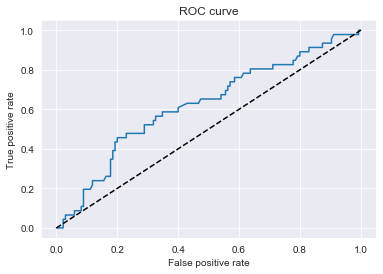

In [90]:
plt.plot(fpr, tpr)
auc = roc_auc_score(X_test['Actual'], X_test['Predicted Prob'])
auc = float("{:.2f}".format(auc))
print("AUC Value: ", auc)

plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [91]:
df_cutoffs = pd.concat([pd.DataFrame(thresholds), pd.DataFrame(fpr), pd.DataFrame(tpr)], axis = 1)
# We concatenate 3 dataframes along the columns.

df_cutoffs.columns = ['thresholds', 'fpr', 'tpr']
# We name the columns of the dataframe 'thresholds', 'fpr', and 'tpr'.

df_cutoffs.head(5)

,thresholds,fpr,tpr
0,1.77,0.00,0.00
1,0.77,0.01,0.00
2,0.75,0.02,0.00
3,0.70,0.02,0.04
4,0.69,0.03,0.04


In [92]:
df_cutoffs['thresholds'][0] = 1 - 1 / np.power(10, 16)
# Let the first threshold (the value of the thresholds column with index 0) be equal to a number, very close to 1
# but smaller than 1, say 1 - 1 / 10 ^ 16.



The score corresponsing to each threshold equals:

The the difference between the natural logarithm of the ratio of the threshold and 1 minus the threshold and the minimum sum of coefficients multiplied by the sum of the minimum score and the ratio of the difference between the maximum score and minimum score and the difference between the maximum sum of coefficients and the minimum sum of coefficients.


In [93]:
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) * ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()
#Here we calculate the scores from proabilities of good

df_cutoffs.head() # Here 1st score is 2019. It's useless. Let's replace it with max_score i.e. 850

,thresholds,fpr,tpr,Score
0,1.00,0.00,0.00,2459.00
1,0.77,0.01,0.00,790.00
2,0.75,0.02,0.00,782.00
3,0.70,0.02,0.04,761.00
4,0.69,0.03,0.04,756.00


In [94]:
df_cutoffs['Score'][0] = max_score
df_cutoffs.head()

,thresholds,fpr,tpr,Score
0,1.00,0.00,0.00,850.00
1,0.77,0.01,0.00,790.00
2,0.75,0.02,0.00,782.00
3,0.70,0.02,0.04,761.00
4,0.69,0.03,0.04,756.00


We define a function below called 'n_approved' which assigns a value of 1 if a predicted probability is greater than the parameter p, which is a threshold, and a value of 0, if it is not. Then it sums the column. Thus, if given any percentage values, the function will return the number of rows wih estimated probabilites greater than the threshold.

In [95]:
def n_approved(p):
    return np.where(X_test['Predicted Prob'] >= p, 1, 0).sum()



    Total = Number of Approved + Number of Rejected
    Approval Rate = Number of Approved/Total
    Rejection Rate = Number of Rejected/Total
    Rejection Rate = 1 - Approval Rate



In [96]:
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Rejected'] = X_test['Predicted Prob'].shape[0] - df_cutoffs['N Approved']
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / X_test['Predicted Prob'].shape[0]
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
# Rejection rate equals one minus approval rate.

df_cutoffs.head()

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.00,0.00,0.00,850.00,0,181,0.00,1.00
1,0.77,0.01,0.00,790.00,1,180,0.01,0.99
2,0.75,0.02,0.00,782.00,3,178,0.02,0.98
3,0.70,0.02,0.04,761.00,5,176,0.03,0.97
4,0.69,0.03,0.04,756.00,6,175,0.03,0.97


As we can see, at PD of 0.40, our approval rate would be 26% and so on.

In [97]:
# We can display all the columns of df1 using this command
pd.set_option('display.max_rows', None)
display(df_cutoffs)

,thresholds,fpr,tpr,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.00,0.00,0.00,850.00,0,181,0.00,1.00
1,0.77,0.01,0.00,790.00,1,180,0.01,0.99
2,0.75,0.02,0.00,782.00,3,178,0.02,0.98
3,0.70,0.02,0.04,761.00,5,176,0.03,0.97
4,0.69,0.03,0.04,756.00,6,175,0.03,0.97
5,0.69,0.03,0.07,756.00,7,174,0.04,0.96
6,0.65,0.06,0.07,743.00,11,170,0.06,0.94
7,0.65,0.06,0.09,741.00,12,169,0.07,0.93
8,0.63,0.08,0.09,732.00,15,166,0.08,0.92
9,0.62,0.08,0.11,732.00,16,165,0.09,0.91


In [98]:
df_scorecard.to_excel("scorecard values.xlsx", sheet_name='Sheet1')

In [99]:
ref_categories_with_p

['Sex_female',
 'Housing_free',
 'Saving accounts_little',
 'Checking account_little',
 'Age:<25',
 'Duration:<7',
 'Loan:<3500']